In [8]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import os
import sys
scripts_path = os.path.abspath('../scripts')
if not scripts_path in sys.path:
    sys.path.insert(1, scripts_path)
    
from transformation import detect_markers_and_compute
from circle_detection import filter_circles, filter_filled_circles, contours_circles, to_circle, ADAPT_THRES_SIZE, ADAPT_THRES_C, BLUR_SIZE, MORPH_ELLIPSE_SIZE, DILATE_ITERS, FILLED_THRES
from run_detection_pipeline import cut_edges

import cv2
import numpy as np
from matplotlib import pyplot as plt
import pytesseract
from pytesseract import Output
from ipywidgets import interact, widgets

In [2]:
W_WORLD, H_WORLD = 420, 297  # size of area marked by inner points of aruco markers in mm
WORLD2IMG_SCALE = 7.5  # scale factor for transforming cm to pixels in the birds eye image
H_IMG, W_IMG = int(H_WORLD * WORLD2IMG_SCALE), int(W_WORLD * WORLD2IMG_SCALE)
BORDER_FRACTION_TO_CUT = 0.01
H_OFFSET = int(H_IMG * BORDER_FRACTION_TO_CUT)
W_OFFSET = int(W_IMG * BORDER_FRACTION_TO_CUT)

In [3]:
def prep(img_path):
    img = cv2.imread(img_path)
    img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    m, debug_img_marker = detect_markers_and_compute(img_gs, (H_IMG, W_IMG), debug_image=True)

    # transform the image into a top down perspective
    img_warped = cv2.warpPerspective(img, m, (W_IMG, H_IMG))
    img_warped_gs = cv2.warpPerspective(img_gs, m, (W_IMG, H_IMG))

    # cut edges
    img_cutted, img_cutted_gs = list(cut_edges([img_warped, img_warped_gs]))
    
    # detect circles and text
    return img_cutted_gs

In [4]:
def detect_circles(src):
    filtered_img = filter_circles(src, ADAPT_THRES_SIZE, ADAPT_THRES_C, 
                                  BLUR_SIZE, MORPH_ELLIPSE_SIZE, DILATE_ITERS)

    # now the image should only contain circles, so find them via contours
    circles = contours_circles(filtered_img)
    filterd_circles = filter_filled_circles(filtered_img, circles, FILLED_THRES)
    return circles, filterd_circles, filtered_img

<IPython.core.display.Javascript object>


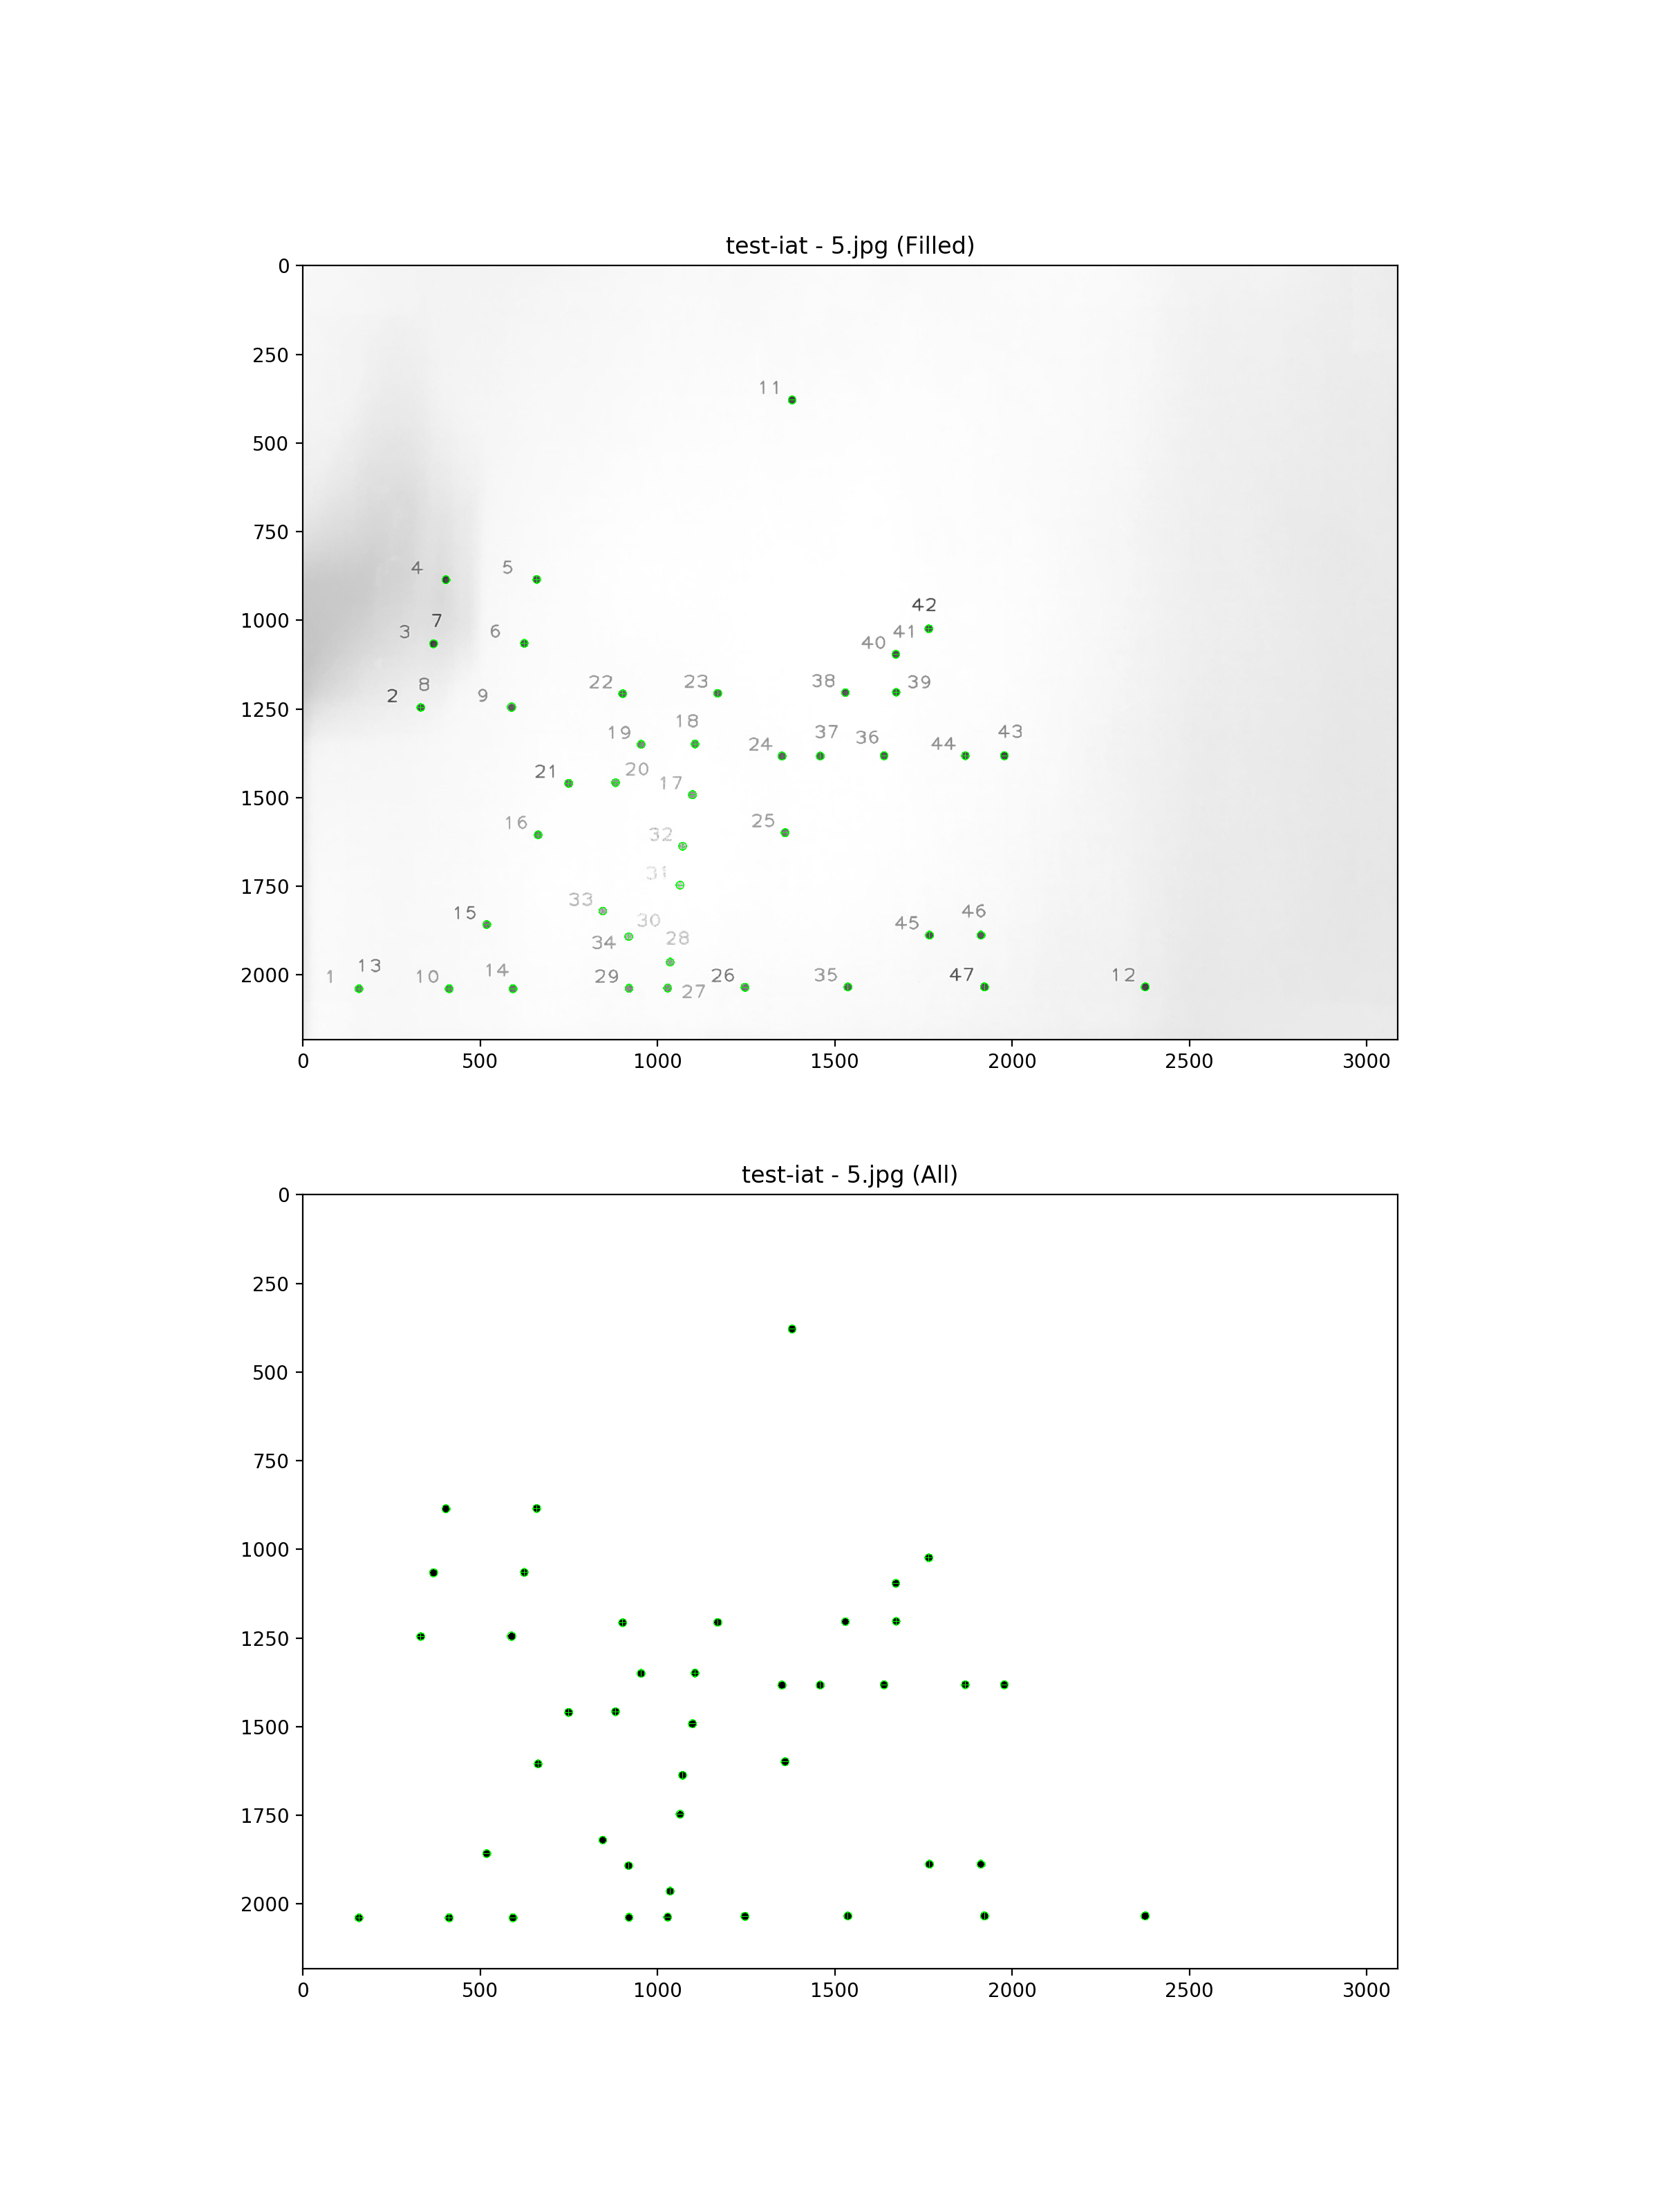

interactive(children=(Dropdown(description='fname', options=('test-iat - 1.jpg', 'test-iat - 10.jpg', 'test-ia…

In [9]:
def showcase_detections(fname):
    img = prep(os.path.abspath(os.path.join('../data/test-images', fname)))
    cs,csf,filt_img = detect_circles(img)
    result = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for c in csf:
        cv2.circle(result, (c.x, c.y), c.r, (0, 255, 0), 2)
        cv2.drawMarker(result, (c.x, c.y), (0, 255, 0))
    filt_result = cv2.cvtColor(filt_img, cv2.COLOR_GRAY2BGR)
    for c in cs:
        cv2.circle(filt_result, (c.x, c.y), c.r, (0, 255, 0), 2)
        cv2.drawMarker(filt_result, (c.x, c.y), (0, 255, 0))
    return result, filt_img, filt_result    

fig, ax = plt.subplots(nrows=2, figsize=(12,16))
result, filt_img, filt_img = showcase_detections('test-iat - 1.jpg')
plot_img_res = ax[0].imshow(result[...,::-1])
plot_img_thres = ax[1].imshow(filt_img[...,::-1])

def update(fname):
    ax[0].set_title(fname+' (Filled)')
    ax[1].set_title(fname+' (All)')
    result, filt_img, filt_img = showcase_detections(fname)
    plot_img_res.set_data(result[...,::-1])
    plot_img_thres.set_data(filt_img[...,::-1])
    fig.canvas.draw_idle()

fnames = sorted([fn for fn in os.listdir('../data/test-images/') if 'iat' in fn])
interact(update, fname=fnames);

In [274]:
mask = filt_img==0
#mask = np.dstack([mask for _ in range(3)])
mask.shape

(2183, 3088, 3)

<IPython.core.display.Javascript object>


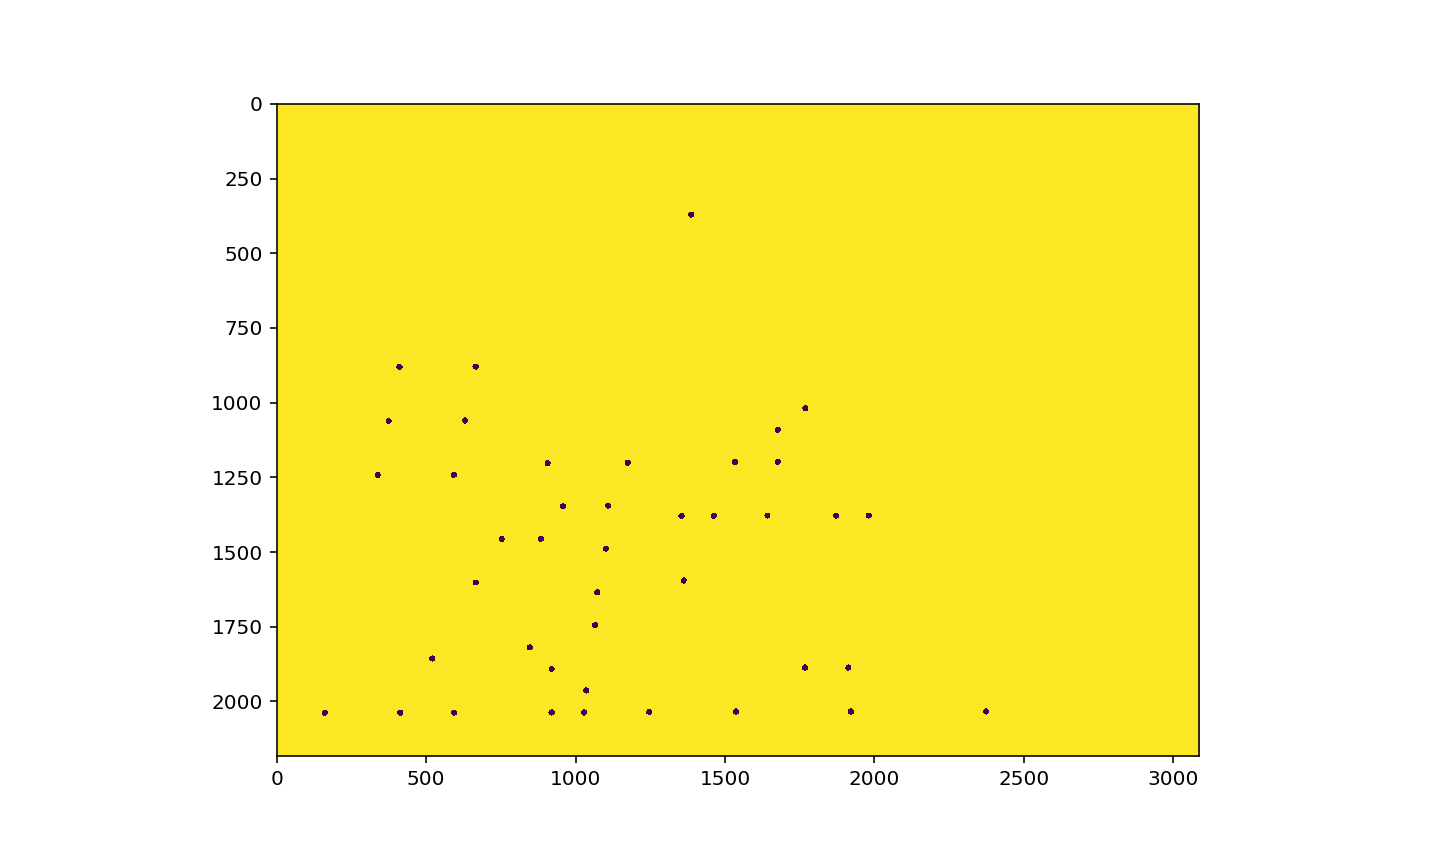

interactive(children=(IntSlider(value=31, description='adap_thres_size', max=150, min=1, step=2), IntSlider(va…

In [203]:
fig, ax = plt.subplots(figsize=(10,6))

plot_img = ax.imshow(filter_circles(img, 41, 31, 1, 3, 1))

def update(adap_thres_size=31, adapt_thres_C=10, blur_size=5, morph_ell_size=7, dilate_iters=2):
    plot_img.set_data(filter_circles(img, adap_thres_size, adapt_thres_C, blur_size, morph_ell_size, dilate_iters))
    fig.canvas.draw_idle()

interact(update, adap_thres_size=(1, 150, 2), adapt_thres_C=(0, 100, 1), 
         blur_size=(1, 15, 2), morph_ell_size=(1, 11, 2), dilate_iters=(1, 10, 1));